In [59]:
%load_ext autoreload
%autoreload 2

from data.projectionsdataset import ProjectionsDataset
from data.emdataset import EMDataset
import matplotlib.pyplot as plt 
from tifffile import imread
from data import transforms
from PIL import Image
from tqdm import tqdm
import open3d as o3d
import numpy as np
import torchvision
import importlib
import warnings
import mrcfile
import astra
import torch
import os
import PIL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
data_path = "data/Au_Ag" 
projections_path = os.path.join(data_path, "Serie_3_ali.tif")
angles_path = os.path.join(data_path, "TiltAngle_ali.txt")
mrc_path = os.path.join(data_path, "Serie_3.mrc")

In [61]:
def get_n_channels(mode):
    return {
        "1": 1,  
        "L": 1,  
        "P": 1,  
        "RGB": 3,  
        "RGBA": 4,  
        "CMYK": 4,  
        "YCbCr": 3,  
        "I": 1,  
        "F": 1,  
    }.get(mode, 1)  


def read_angles_file(filepath: str) -> torch.Tensor:
    with open(filepath, 'r') as file:
        lines = file.readlines()
    
    return torch.from_numpy( np.array([float(line.strip()) for line in lines], dtype=np.float32) )


def estimate_memory(n, size, channels=1, dtype=torch.uint8):

    bytes_per_pixel = torch.tensor([], dtype=dtype).element_size()
    
    memory_per_image = size[0] * size[1] * channels * bytes_per_pixel
    
    total_memory_bytes = n * memory_per_image
    
    print( f"Storing this object uses: {total_memory_bytes / 1024**2} MB of memory" )

def tensor_memory_usage(tensor: torch.Tensor) -> float:
    num_elements = tensor.numel()
    element_size = tensor.element_size()
    total_size_in_bytes = num_elements * element_size
    print( f"Storing this tensor uses: {total_size_in_bytes / 1024**2} MB of memory" )
    
def get_vram_info():
    total_vram = torch.cuda.get_device_properties(0).total_memory
    allocated_vram = torch.cuda.memory_allocated(0)
    free_vram = total_vram - allocated_vram
    return total_vram, allocated_vram, free_vram

In [62]:
target_img_size = 128
dataset = EMDataset("cpu", projections_path, angles_path, target_img_size)

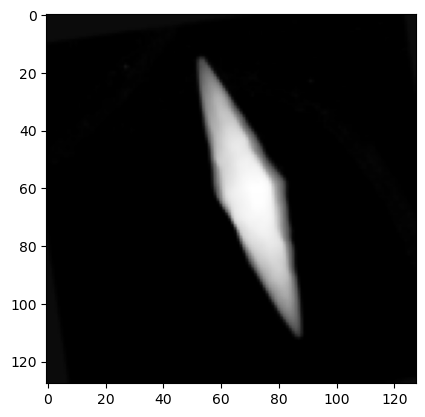

In [63]:
plt.imshow(  dataset.images_tensor[50].permute(1, 2, 0), cmap="Greys_r" )

In [64]:
@torch.no_grad
def plot_rays(origins, directions, directions_scale = 0.1, show_directions=False, directions_subsample=1):
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(origins)
    
    geometries = [point_cloud]
    if show_directions:
        lines = []
        line_points = []

        for origin, direction in zip(origins[::directions_subsample], 
                                     directions[::directions_subsample]):
            
            end_point = origin + direction * directions_scale
            line_points.append(origin)
            line_points.append(end_point)
            lines.append([len(line_points) - 2, len(line_points) - 1])

        line_points = np.array(line_points)
        lines = np.array(lines)

        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(line_points)
        line_set.lines = o3d.utility.Vector2iVector(lines)

        geometries.append(line_set)

    o3d.visualization.draw_geometries(geometries)

In [65]:
def read_tif(filepath, target_size) -> torch.Tensor: 

    with Image.open(filepath) as im:

        if im.mode != "L":
            print(f"Image mode ({im.mode}) different than the expected 'L' (8-bit grayscale) this may lead to improper processing")

        n_channels = get_n_channels(im.mode)
        tensor_shape = (im.n_frames, n_channels, target_size, target_size)
        image_tensor = torch.zeros(tensor_shape, dtype=torch.uint8) 

        for i in range(im.n_frames):
            im.seek(i)

            np_array = np.array(im) 
            image = transforms.au_ag(np_array,target_size)
            
            image_tensor[i] = torch.from_numpy(image).permute(2, 0, 1) 
        
        image_tensor = image_tensor.float() / 255.0

        return image_tensor 

def read_angles_file(file_path):
    return np.loadtxt(file_path)


data_path = "data/Au_Ag"
projections_path = os.path.join(data_path, "Serie_3_ali.tif")
angles_path = os.path.join(data_path, "TiltAngle_ali.txt")


images_tensor = read_tif(projections_path, target_img_size)
angles_tensor = np.deg2rad(read_angles_file(angles_path))
angles_tensor = np.array(angles_tensor).flatten()


num_projections = images_tensor.shape[0]

detector_size_y = images_tensor.shape[1]
detector_size_x = images_tensor.shape[2]

vol_size = images_tensor.shape[1]
print(images_tensor.shape)

# images_tensor = np.transpose(images_tensor, (1, 0, 2))


# vol_geom = astra.create_vol_geom(vol_size, vol_size, vol_size)
# proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, detector_size_y, detector_size_x, angles_tensor)


# sinogram_id = astra.data3d.create('-sino', proj_geom, images_tensor)
# projector_id = astra.create_projector('cuda3d', proj_geom, vol_geom)

# vectors = astra.geom_2vec(proj_geom)["Vectors"]

torch.Size([75, 1, 128, 128])


In [66]:
def create_geometry_vectors(angles, detector_spacing_X=1.0, detector_spacing_Y=1.0):

    vectors = np.zeros((len(angles), 12))
    for i in range(len(angles)):

        # ray direction
        vectors[i, 0] = np.sin(angles[i])
        vectors[i, 1] = -np.cos(angles[i])
        vectors[i, 2] = 0

        # center of detector
        vectors[i, 3] = 0
        vectors[i, 4] = 0
        vectors[i, 5] = 0

        # vector from detector pixel (0,0) to (0,1)
        vectors[i, 6] = np.cos(angles[i]) * detector_spacing_X
        vectors[i, 7] = np.sin(angles[i]) * detector_spacing_X
        vectors[i, 8] = 0

        # vector from detector pixel (0,0) to (1,0)
        vectors[i, 9] = 0
        vectors[i, 10] = 0
        vectors[i, 11] = detector_spacing_Y

    return vectors

In [67]:
vectors = create_geometry_vectors(angles_tensor)

In [68]:
# def compute_ray(vec, u, v, factor=10):

#     ray_direction = vec[:3]
#     det_center    = vec[3:6]
#     width_vec     = vec[6:9]
#     height_vec    = vec[9:12]

#     pixel_location = det_center + u * width_vec + v * height_vec # pixel location on the projection
#     ray_origin = pixel_location + ray_direction * factor         # the origin of the ray is the pixel location translated by the direction times a factor away
#     return ray_origin, -ray_direction

# size = 1024 # size of the projection
# n_proj = 1  # number of projections

# origins    = np.zeros((n_proj, size, size, 3))
# directions = np.zeros((n_proj, size, size, 3))

# for p in range(n_proj):
#     for i in range(-size//2,size//2):
#         for j in range(-size//2, size//2):
#             origins[p, i, j], directions[p, i, j] = compute_ray(vectors[p], i, j)



# origins_reshaped = origins.reshape(-1, 3)
# directions_reshaped = directions.reshape(-1, 3)

# plot_rays(origins_reshaped, directions_reshaped, scale=1, show_dir=False)

In [69]:
# def compute_rays(vecs, size):
#     factor=(size * np.sqrt(3)) / 2
#     u, v = np.meshgrid(np.arange(-size//2, size//2), np.arange(-size//2, size//2), indexing='ij')
#     u = u.reshape(-1)
#     v = v.reshape(-1)
    
#     origins = np.zeros((vecs.shape[0], size*size, 3))
#     directions = np.zeros((vecs.shape[0], size*size, 3))
    
#     for p in range(vecs.shape[0]):
#         ray_direction = vecs[p, :3]
#         det_center = vecs[p, 3:6]
#         width_vec = vecs[p, 6:9]
#         height_vec = vecs[p, 9:12]
        
#         pixel_locations = det_center + u[:, None] * width_vec + v[:, None] * height_vec
#         origins[p] = pixel_locations + ray_direction * factor
#         directions[p] = -ray_direction
    
#     return origins.reshape(-1, 3), directions.reshape(-1, 3)

# origins_reshaped, directions_reshaped = compute_rays(vectors, size)

In [70]:
@torch.no_grad
def compute_rays_torch(vecs, size, factor_scale=50):
    factor = ((size * np.sqrt(3)) / 2)*factor_scale
        
    u, v = torch.meshgrid(torch.arange(-size//2, size//2), torch.arange(-size//2, size//2), indexing='ij')
    u = u.reshape(-1)
    v = v.reshape(-1)
    
    vecs = torch.tensor(vecs, dtype=torch.float64)
    n_projections = vecs.shape[0]

    origins = torch.zeros((n_projections, size * size, 3), dtype=torch.float64)
    directions = torch.zeros((n_projections, size * size, 3), dtype=torch.float64)
    
    for p in range(n_projections):
        ray_direction = vecs[p, :3]
        det_center = vecs[p, 3:6]
        width_vec = vecs[p, 6:9]
        height_vec = vecs[p, 9:12]
        
        pixel_locations = det_center + u[:, None] * width_vec + v[:, None] * height_vec
        origins[p] = pixel_locations + ray_direction * factor
        directions[p] = -ray_direction
    
    return origins.reshape(-1, 3), directions.reshape(-1, 3)

size = target_img_size  # size of the projection
n_proj = 75 # number of projections

origins_reshaped, directions_reshaped = compute_rays_torch(vectors[:n_proj], size, factor_scale=50)

# plot_rays(origins_reshaped, 
#           directions_reshaped, 
#           show_directions=True,
#           directions_scale=6000, 
#           directions_subsample=500)

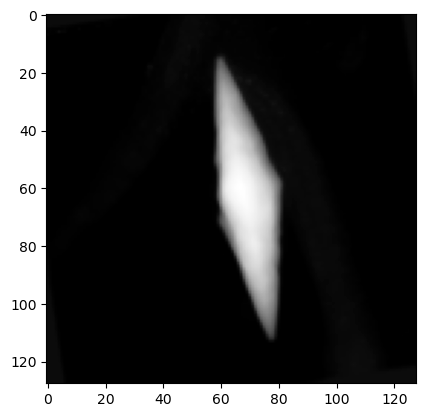

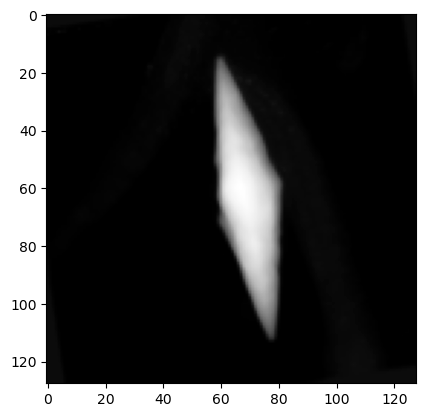

In [92]:
idx = 74
im_s = target_img_size*target_img_size
plt.imshow(dataset.data[idx*im_s:idx*im_s+im_s, 6].reshape(target_img_size, target_img_size), cmap='Greys_r')
plt.show()
plt.imshow(images_tensor[idx].reshape(target_img_size, target_img_size), cmap='Greys_r')
plt.show()

In [72]:
diff_indices = (dataset.data[:target_img_size*target_img_size, 6] != images_tensor[0].flatten()).nonzero(as_tuple=True)[0]

print(len(diff_indices))  # Output: tensor([1, 3])

0


In [85]:
print(images_tensor[0, 0, :].flatten().shape)

torch.Size([16384])


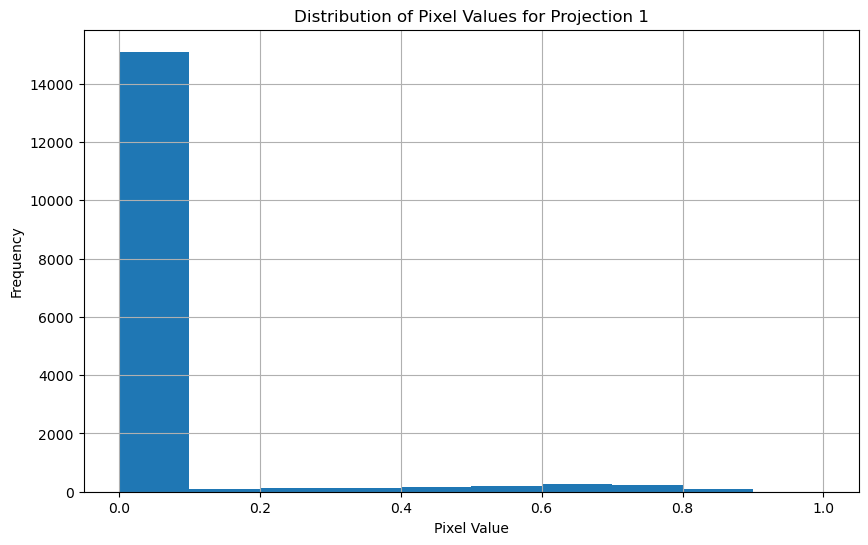

In [116]:
def plot_pixel_distribution(tensor):
    tensor = tensor.numpy()  # Convert to numpy array
    proj, c, h, w = tensor.shape
    
    for i in range(proj):
        pixels:torch.Tensor = tensor[i].flatten()  # Flatten the pixels of the current projection
        plt.figure(figsize=(10, 6))
        plt.hist(pixels, range=(0, 1))
        plt.title(f'Distribution of Pixel Values for Projection {i+1}')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

plot_pixel_distribution(images_tensor[:1])

In [104]:
im =  imread(projections_path)


(75, 1024, 1024)

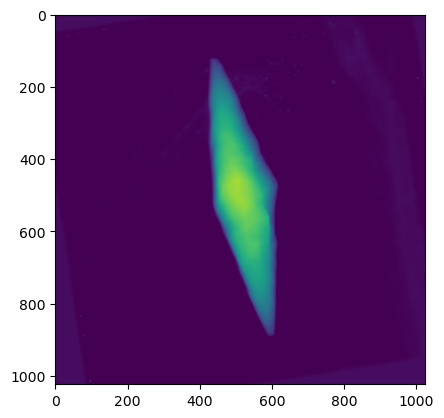

In [107]:
plt.imshow(im[0])

In [111]:
images_tensor[0, 0, 64, 64]

tensor(0.8431)

In [109]:
im[0, 512, 512]

216